<a href="https://colab.research.google.com/github/marzhar/marzhar/blob/main/Copy_of_Methane_Detection_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# source: https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-geospatial/methane-emission-monitoring/monitor_methane_ch4_emission_point_sources.ipynb
# https://github.com/sentinel-hub/sentinel2-cloud-detector/blob/master/examples/sentinel2-cloud-detector-example.ipynb
! pip install s2cloudless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.4/245.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.6 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6084 sha256=5471711c3a7ec31d9edd98884bd4034a04ff7b1dea9cb3889d49355b14d3fed4
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [ ]:
!pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 27.3 MB/s eta 0:00:00


In [ ]:
# source: https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-geospatial/methane-emission-monitoring/monitor_methane_ch4_emission_point_sources.ipynb
import os
import json
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import warnings
from shapely import wkt, geometry
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import IPython.display
import rasterio
from rasterio.plot import show
from sentinelhub import CRS, BBox, DataCollection, SHConfig, SentinelHubCatalog, SentinelHubRequest,MimeType, bbox_to_dimensions, MosaickingOrder, generate_evalscript# https://sentinelhub-py.readthedocs.io/en/latest/configure.html
from datetime import datetime
from typing import Any, Optional, Tuple
from s2cloudless import S2PixelCloudDetector, download_bands_and_valid_data_mask
from sentinelhub.api.catalog import get_available_timestamps

In [ ]:
def bbox_around_point(lon, lat, distance_offset=1500, output_projection="EPSG:4326"):
    """
    Create a square bounding box of size distance_offset*2 by distance_offset*2
    with the provided coordinates as centroid
    """

    gs = gpd.GeoSeries(wkt.loads(f"POINT ({lon} {lat})"))
    gdf = gpd.GeoDataFrame(geometry=gs)
    gdf.crs = "EPSG:4326"
    gdf = gdf.to_crs("EPSG:3857")  # <-- change crs to a projection crs, e.g., Web Mercator
    res = gdf.buffer(
        distance=distance_offset,
        cap_style=3,  # <-- ensure sharp edges
    )

    if output_projection != "EPSG:3857":
        res = res.to_crs(output_projection)

    return res.iloc[0]

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
config = SHConfig()

config.sh_client_id = "sh-26bba4f0-3626-48f0-98af-8952fe4df97a"
config.sh_client_secret = "zGzoWVt7MBH6EH9McqkQekjVDvivWI21"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")
# Saved config can be later accessed with config = SHConfig("cdse")

config = SHConfig("cdse")

In [ ]:
# coordinates and date for North Africa oil field (common reference in earth observation literature)
# https://amt.copernicus.org/articles/14/2771/2021/
point_longitude = 5.9053
point_latitude = 31.6585
date_to_monitor = "2019-11-20"

# size of bounding box in each direction around point
distance_offset_meters = 1500

In [ ]:
resolution = 10
aoi_geometry = bbox_around_point(point_longitude, point_latitude, distance_offset_meters)
# aoi_coords_wgs84 = [4.20762, 50.764694, 4.487708, 50.916455]
aoi_coords_wgs84 = list(aoi_geometry.bounds)
aoi_bbox = BBox(aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)
print(f'Image shape at {resolution} m resolution: {aoi_size} pixels')

Image shape at 10 m resolution: (249, 261) pixels


In [ ]:
data_collection_new = DataCollection.SENTINEL2_L1C.define_from(
                name="s3", service_url="https://sh.dataspace.copernicus.eu"
            )
timestamps = get_available_timestamps(
    data_collection=data_collection_new, bbox=aoi_bbox, time_interval=(date_to_monitor, date_to_monitor), config=config
)
timestamps

[datetime.datetime(2019, 11, 20, 10, 22, 6, 441000),
 datetime.datetime(2019, 11, 20, 10, 22, 8, 271000)]

In [ ]:
bands, masks = download_bands_and_valid_data_mask(data_collection=data_collection_new,bbox=aoi_bbox, size=aoi_size, timestamps=timestamps, config=config)

In [ ]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=1, dilation_size=1, all_bands=True)

probability_maps = cloud_detector.get_cloud_probability_maps(bands)
cloud_mask = cloud_detector.get_mask_from_prob(probability_maps)

In [ ]:
true_color_images = np.clip(bands[..., [3, 2, 1]] * 2, 0, 1)

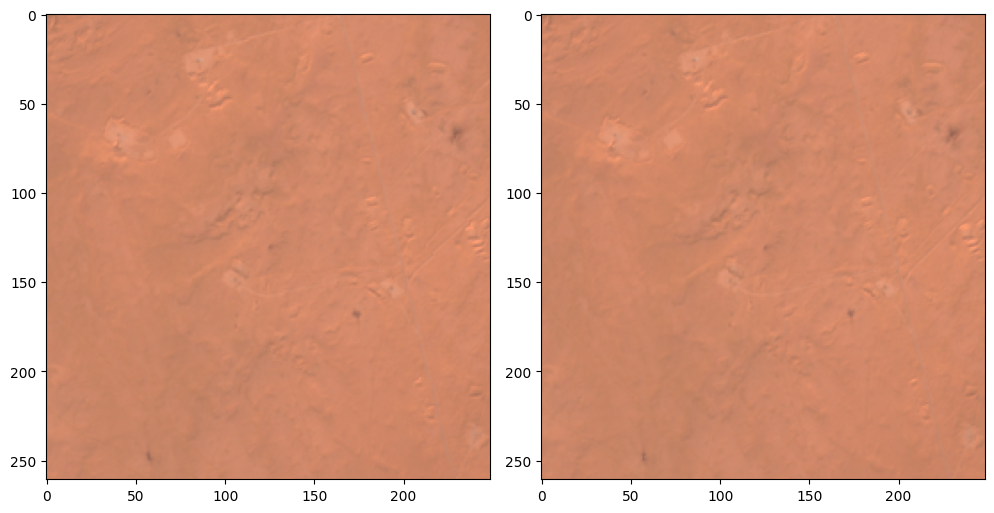

In [ ]:
fig = plt.figure(figsize=(15, 10))
n_cols = 3
n_rows = int(np.ceil(len(true_color_images) / n_cols))

for idx, (image, mask) in enumerate(zip(true_color_images, cloud_mask)):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    ax.imshow(image)
    ax.imshow(mask, cmap="gnuplot", alpha=0.5 * (mask > 0))

plt.tight_layout()

In [ ]:
def get_all_bands(point_longitude, point_latitude, distance_offset_meters, resolution, timestamps, data_collection,config, output_projection="EPSG:4326"):
    aoi_geometry = bbox_around_point(point_longitude, point_latitude, distance_offset_meters,output_projection)
    aoi_coords_wgs84 = list(aoi_geometry.bounds)
    aoi_bbox = BBox(aoi_coords_wgs84, crs=CRS.WGS84)
    aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)
    all_bands, _ = download_bands_and_valid_data_mask(data_collection=data_collection,bbox=aoi_bbox, size=aoi_size, timestamps=timestamps, config=config)

    cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=1, dilation_size=1, all_bands=True)

    probability_maps = cloud_detector.get_cloud_probability_maps(all_bands)
    cloud_mask = cloud_detector.get_mask_from_prob(probability_maps)
    return all_bands, cloud_mask

In [ ]:
data_collection_new = DataCollection.SENTINEL2_L1C.define_from(
                name="s3", service_url="https://sh.dataspace.copernicus.eu"
            )
timestamps = get_available_timestamps(
    data_collection=data_collection_new, bbox=aoi_bbox, time_interval=(date_to_monitor, date_to_monitor), config=config
)
timestamps

[datetime.datetime(2019, 11, 20, 10, 22, 6, 441000),
 datetime.datetime(2019, 11, 20, 10, 22, 8, 271000)]

In [ ]:
preview_distance_offset = distance_offset_meters*2
all_bands,cloud_mask = get_all_bands(point_longitude, point_latitude, preview_distance_offset, resolution*2, timestamps, data_collection_new,config)
visual_bands = all_bands[..., [3, 2, 1]]

In [ ]:
rgb = visual_bands[0]
rgb = np.clip(visual_bands[0] * 2, 0,1)

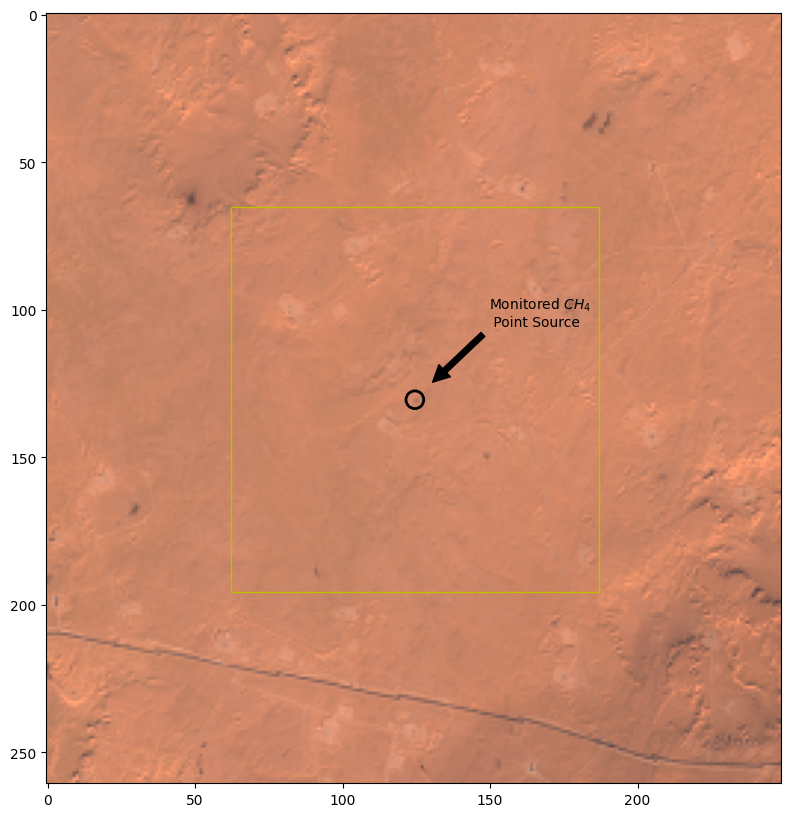

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb)

height = rgb.shape[0]
width = rgb.shape[1]
y_m_per_pixel = preview_distance_offset * 2 / height
x_m_per_pixel = preview_distance_offset * 2 / width

y_distance_offset = distance_offset_meters / y_m_per_pixel
x_distance_offset = distance_offset_meters / x_m_per_pixel

p = patches.Circle(
    (width / 2, height / 2), radius=3, linewidth=2, edgecolor="black", facecolor="none"
)

rect = patches.Rectangle(
    (width / 2 - x_distance_offset, height / 2 - y_distance_offset),
    x_distance_offset * 2,
    y_distance_offset * 2,
    linewidth=1,
    edgecolor="y",
    facecolor="none",
)
ax.add_patch(p)
ax.add_patch(rect)

ax.annotate(
    "Monitored $CH_4$\n Point Source",
    xy=(width / 2 + 5, height / 2 - 5),
    xytext=(width / 2 + 25, height / 2 - 25),
    arrowprops=dict(facecolor="black", shrink=0.05),
    ha="left",
)

plt.show()

In [ ]:
from datetime import datetime, timedelta

def compute_new_date(date_string, day_offset):
    # Convert the input date string to a datetime object
    date = datetime.strptime(date_string, '%Y-%m-%d')

    # Subtract the specified number of days from the date
    new_date = date - timedelta(days=day_offset)

    # Format the new date as a string
    new_date_string = new_date.strftime('%Y-%m-%d')

    return new_date_string

In [ ]:
def remove_cloud_from_images(all_bands, cloud_mask):
    # Determine the number of bands
    num_bands = len(all_bands)

    # Create an empty list to store the cloud-free images
    no_cloud_images = []

    # Loop over each band and corresponding cloud mask
    for (image, mask) in zip(all_bands, cloud_mask):
        non_cloud_mask = ~(mask > 0)
        no_cloud_image = np.zeros_like(image)
        no_cloud_image[non_cloud_mask] = image[non_cloud_mask]
        no_cloud_images.append(no_cloud_image)

    # Convert the list to a NumPy ndarray
    no_cloud_images_array = np.stack(no_cloud_images, axis=0)

    return no_cloud_images_array

In [ ]:
day_offset = 30
new_date_string = compute_new_date(date_to_monitor, day_offset)
timestamps = get_available_timestamps(
    data_collection=data_collection_new, bbox=aoi_bbox, time_interval=(new_date_string, date_to_monitor), config=config
)
timestamps


[datetime.datetime(2019, 10, 21, 10, 22, 8, 613000),
 datetime.datetime(2019, 10, 21, 10, 22, 10, 441000),
 datetime.datetime(2019, 10, 24, 10, 32, 4, 398000),
 datetime.datetime(2019, 10, 24, 10, 32, 6, 863000),
 datetime.datetime(2019, 10, 26, 10, 22, 6, 356000),
 datetime.datetime(2019, 10, 26, 10, 22, 8, 180000),
 datetime.datetime(2019, 10, 29, 10, 32, 1, 928000),
 datetime.datetime(2019, 10, 29, 10, 32, 4, 410000),
 datetime.datetime(2019, 10, 31, 10, 22, 8, 541000),
 datetime.datetime(2019, 10, 31, 10, 22, 10, 368000),
 datetime.datetime(2019, 11, 3, 10, 32, 4, 118000),
 datetime.datetime(2019, 11, 3, 10, 32, 6, 580000),
 datetime.datetime(2019, 11, 5, 10, 22, 5, 473000),
 datetime.datetime(2019, 11, 5, 10, 22, 7, 298000),
 datetime.datetime(2019, 11, 8, 10, 32, 0, 836000),
 datetime.datetime(2019, 11, 8, 10, 32, 3, 320000),
 datetime.datetime(2019, 11, 10, 10, 22, 7, 801000),
 datetime.datetime(2019, 11, 10, 10, 22, 9, 625000),
 datetime.datetime(2019, 11, 13, 10, 32, 3, 231000

In [ ]:
all_bands,cloud_mask = get_all_bands(point_longitude, point_latitude, distance_offset_meters, resolution, timestamps, data_collection_new,config)
no_cloud_images=remove_cloud_from_images(all_bands,cloud_mask)

In [ ]:
def approximate_best_baseline_date(bands12,timestamps):
    max_mean_swir = None
    sel_idx = 0
    for idx,target_band_data in enumerate(bands12):
        mean_swir = target_band_data.mean()
        visible_area_ratio = float(np.count_nonzero(target_band_data))/ float(target_band_data.shape[0]*target_band_data.shape[1])
        if visible_area_ratio <= 0.7:
                    continue
        if max_mean_swir is None or mean_swir > max_mean_swir:
            max_mean_swir = mean_swir
            sel_idx = idx
    return timestamps[sel_idx], sel_idx

In [ ]:
bands12 = no_cloud_images[..., 11]
baseline_date,sel_idx = approximate_best_baseline_date(bands12,timestamps)
baseline_date


datetime.datetime(2019, 10, 26, 10, 22, 8, 180000)

In [ ]:
bands11 = no_cloud_images[..., 11]
bands12 = no_cloud_images[..., 12]
l1_b11_base = bands11[sel_idx]
l1_b12_base = bands12[sel_idx]
monitor_idx = -2
l1_b11_monitor = bands11[monitor_idx]
l1_b12_monitor = bands12[monitor_idx]

In [ ]:
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

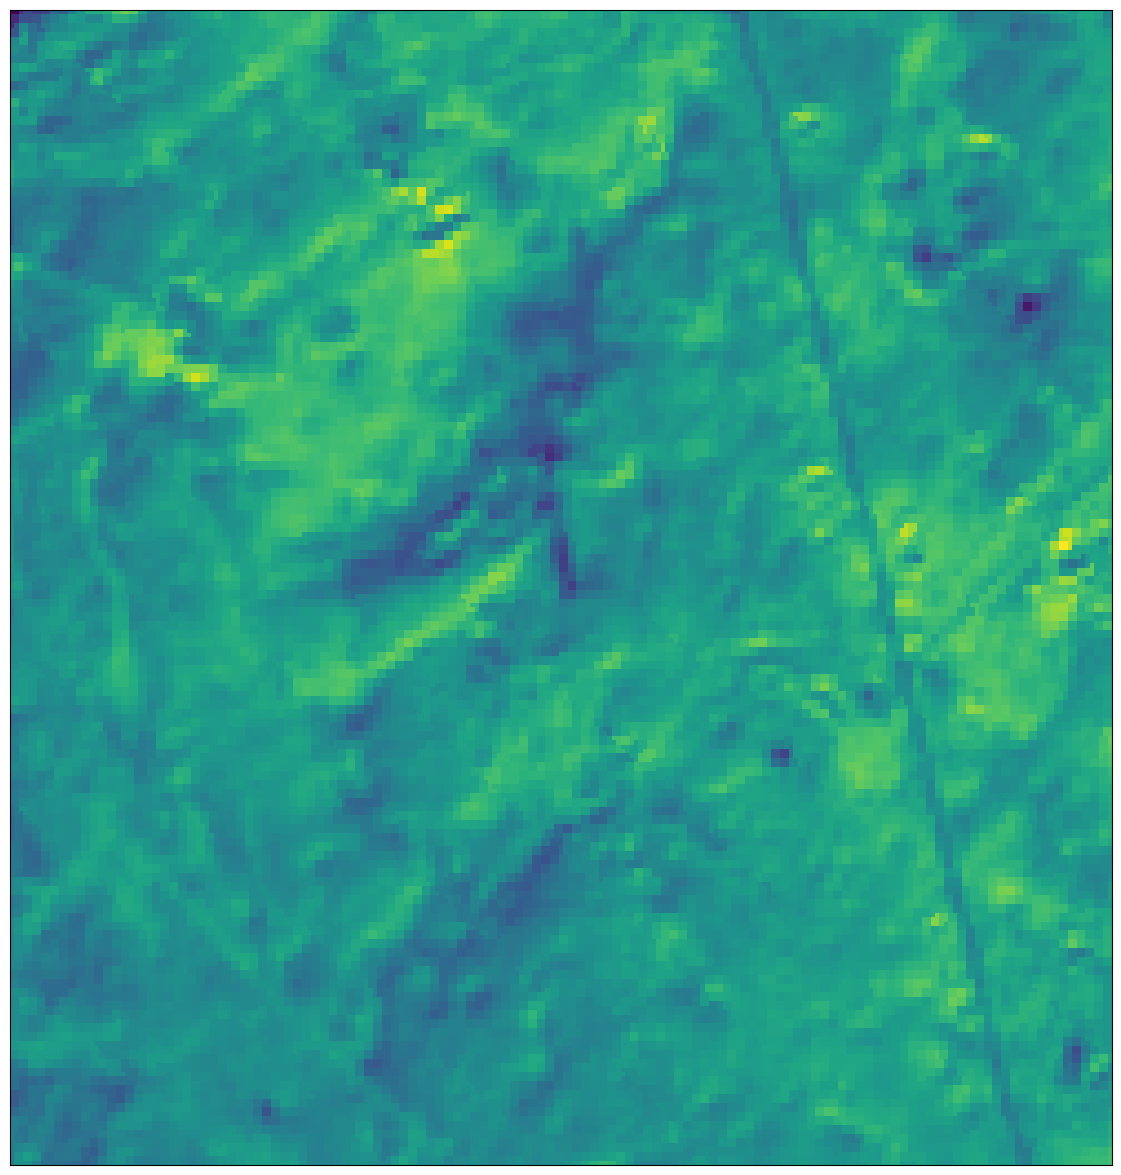

In [ ]:
plot_image(l1_b12_monitor, factor=1, clip_range=(0, 1))

In [ ]:
def compute_correction_factor(tif_y, tif_x):
    """
    Compute a correction factor c via linera regression
    with the following equation: tif_y = c*tif_x
    """

    # get flattened arrays for regression
    y = tif_y.flatten()
    x = tif_x.flatten()

    np.nan_to_num(y, copy=False)
    np.nan_to_num(x, copy=False)

    assert y.shape == x.shape, "Shapes of two provided TIFs are incompatible!"

    # fit linear model using least squares regression
    x = x[:, np.newaxis]
    c, _, _, _ = np.linalg.lstsq(x, y, rcond=None)

    return c[0]
def compute_corrected_fractional_reflectance_change(
    l1_b11_base, l1_b12_base, l1_b11_monitor, l1_b12_monitor, correction=True
):
    """
    Compute multi-band-multi-pass fractional reflectance change
    between base and monitoring scene
    """
    # get correction factor
    c_monitor = compute_correction_factor(tif_y=l1_b11_monitor, tif_x=l1_b12_monitor)
    c_base = compute_correction_factor(tif_y=l1_b11_base, tif_x=l1_b12_base)

    # get corrected fractional reflectance change
    if correction:
        frac_change = ((c_monitor * l1_b12_monitor - l1_b11_monitor) / l1_b11_monitor) - (
            (c_base * l1_b12_base - l1_b11_base) / l1_b11_base
        )
    else:
        frac_change = ((l1_b12_monitor - l1_b11_monitor) / l1_b11_monitor) - (
            (l1_b12_base - l1_b11_base) / l1_b11_base
        )
    return frac_change

In [ ]:
l1_b11_monitor.flatten()

array([0.5093, 0.5093, 0.5294, ..., 0.6082, 0.6082, 0.6084], dtype=float32)

In [ ]:
frac_change = compute_corrected_fractional_reflectance_change(l1_b11_base, l1_b12_base, l1_b11_monitor, l1_b12_monitor)
frac_change

array([[-0.01966836, -0.01966836, -0.00661899, ...,  0.0068985 ,
        -0.02033404,  0.00526793],
       [-0.02459543, -0.02459543, -0.01094042, ...,  0.0068985 ,
        -0.02033404,  0.00526793],
       [-0.02459543, -0.02459543, -0.01094042, ...,  0.01150875,
        -0.01061864,  0.01505177],
       ...,
       [-0.00336432,  0.00687339,  0.00391157, ...,  0.00266563,
         0.00021354,  0.00785612],
       [-0.00336432,  0.00687339,  0.00391157, ...,  0.00696672,
         0.00451462,  0.01195061],
       [-0.00903517,  0.00615695, -0.00430178, ...,  0.00085136,
         0.00430669,  0.01174268]], dtype=float32)

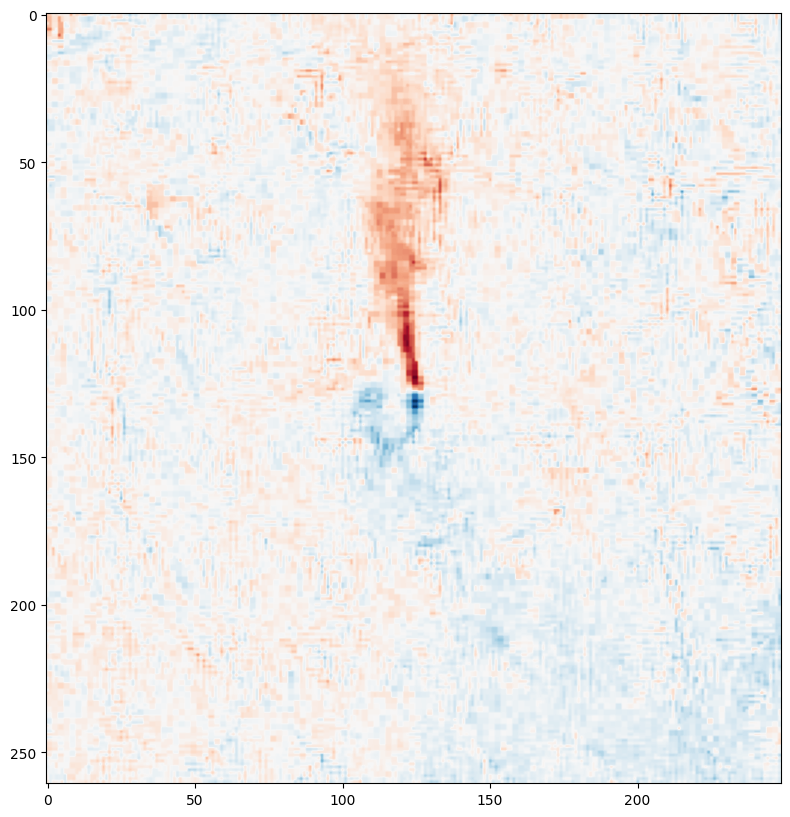

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(frac_change, cmap="RdBu")

In [ ]:
print(frac_change.max())
print(frac_change.min())

0.08018065
-0.08013531


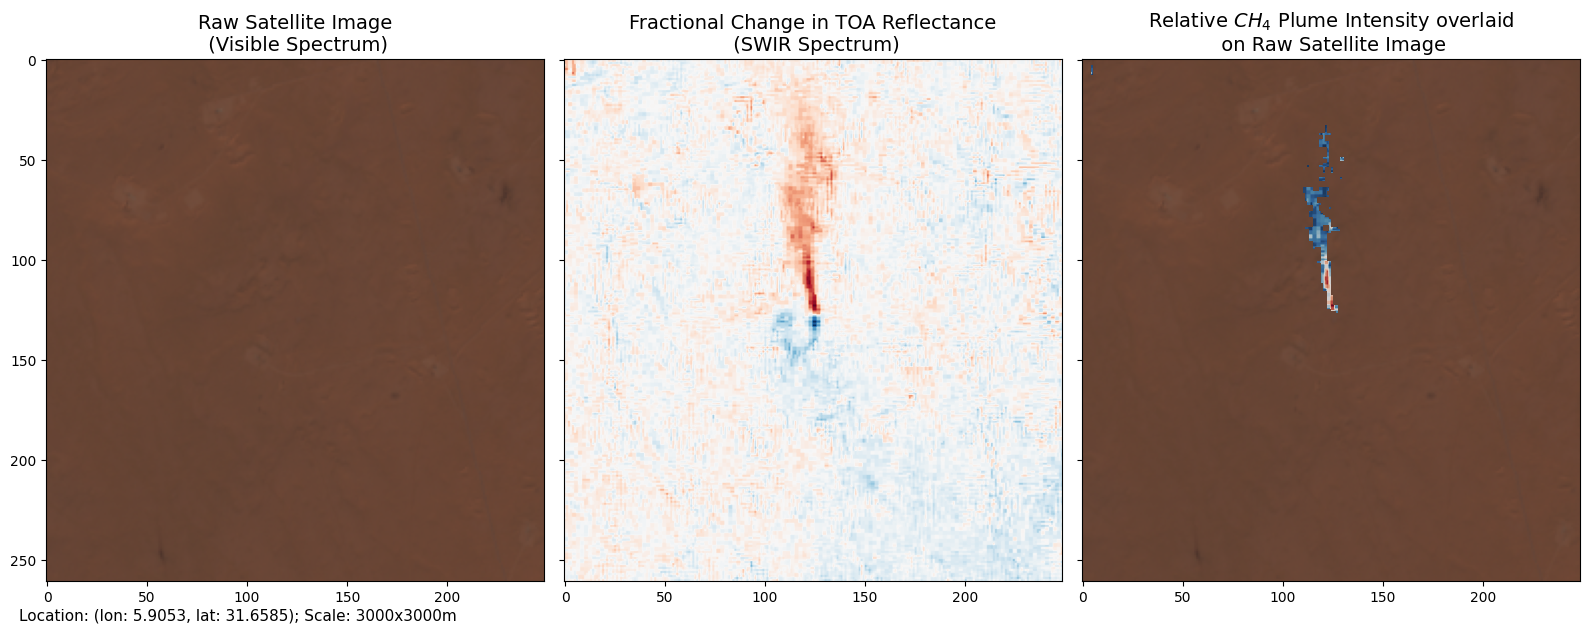

In [ ]:
treshold_value = -0.025
visual_bands = no_cloud_images[..., [3, 2, 1]]
rgb = visual_bands[0]


cr_masked = frac_change.copy()
cr_masked[cr_masked > treshold_value] = np.nan

m = np.ma.array(cr_masked, mask=cr_masked == np.nan)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharex=True, sharey=True)

ax = axes[0]
ax.imshow(rgb)
ax.set_title("Raw Satellite Image\n (Visible Spectrum)", fontsize=14)

ax = axes[1]
ax.imshow(frac_change, cmap="RdBu")  # <-- uses interpolated data
ax.set_title("Fractional Change in TOA Reflectance\n (SWIR Spectrum)", fontsize=14)

ax = axes[2]
ax.imshow(rgb)
ax.imshow(m, alpha=0.8, cmap="RdBu")
ax.set_title("Relative $CH_4$ Plume Intensity overlaid\n on Raw Satellite Image", fontsize=14)

for ax in axes:
    ax.grid(False)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
txt = f"Location: (lon: {point_longitude}, lat: {point_latitude}); Scale: {distance_offset_meters*2}x{distance_offset_meters*2}m"
# txt = f"Location: (lon: {point_longitude}, lat: {point_latitude}); Reference Tile Id: {change_reflectance.attrs['s2_tile_id_baseline']}; Monitoring Tile Id: {change_reflectance.attrs['s2_tile_id_monitor']}; Scale: {distance_offset_meters*2}x{distance_offset_meters*2}m"
# plt.figtext(0.015, 0.25, txt, wrap=False, horizontalalignment="left", fontsize=11)
plt.figtext(0.015, 0.2, txt, wrap=False, horizontalalignment="left", fontsize=11)

plt.tight_layout()

plt.show()